In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import time
import torch
import torch.optim as optim
from matic_pytorch import GP_adapter

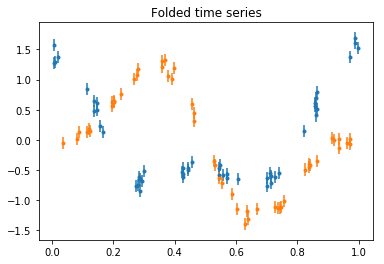

In [2]:
# Mock data to test
N = 50
s_noise = 0.1
per = np.array([1.4284, 0.8465])

t = np.linspace(0.0, 10.0, num=N)
t1 = t + 0.1*(10/N)*np.random.randn(N)
t1 = np.sort(t1)
v1_clean = np.cos(2.0*np.pi*t1/per[0]) + 0.5*np.cos(4.0*np.pi*t1/per[0]) 
v1 = v1_clean + s_noise*np.random.randn(N)
e1 = s_noise*np.ones_like(v1)
t2 = t + 0.1*(10/N)*np.random.randn(N)
t2 = np.sort(t2)
v2_clean = np.sin(2.0*np.pi*t2/per[1]) - 0.5*np.sin(4.0*np.pi*t2/per[1]) 
v2 = v2_clean + s_noise*np.random.randn(N)
e2 = s_noise*np.ones_like(v2)

mjd = list((t1, t2))
mag = list((v1, v2))
err = list((e1, e2))
labels = [0, 1]
for i in range(2):
    plt.errorbar(np.mod(mjd[i], per[i])/per[i], mag[i], err[i], fmt='.')    
plt.title("Folded time series");

In [9]:
# Parameters
n_mc_samples = 32
n_pivots = 100
n_neuron_conv = 8
n_neuron_fc = 64
n_classes = 2     

net = GP_adapter(n_pivots=n_pivots, n_mc_samples=n_mc_samples, n_neuron_conv=n_neuron_conv, n_classes=n_classes)
print(net)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()

for k in range(100): # epochs
    for i in range(2): # data samples
        targets = torch.tensor(labels[i]).repeat(n_mc_samples)
        output = net(torch.from_numpy(mjd[i]).float(), 
                     mag=torch.from_numpy(mag[i]).float(), 
                     err = torch.from_numpy(err[i]).float(), 
                     P=per[i])
        optimizer.zero_grad()
        loss = criterion(output, targets)
        #print(k, loss.item())
        loss.backward()
        optimizer.step()

GP_adapter(
  (conv1): Conv1d(1, 8, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=400.0, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [8]:
for i in range(2):
    pred_proba=torch.exp(net.forward(torch.from_numpy(mjd[i]).float(), 
            torch.from_numpy(mag[i]).float(), 
            torch.from_numpy(err[i]).float(), P=per[i])).detach().numpy()
    pred_label= np.argmax(np.mean(pred_proba, axis=0))
    print("%d: Predicted class %d, Average pbb:%f, std_dev:%f" %(i, pred_label, 
                                                                 np.mean(pred_proba, axis=0)[i], np.std(pred_proba, axis=0)[i]))

0: Predicted class 0, Average pbb:0.984796, std_dev:0.018303
1: Predicted class 1, Average pbb:0.984093, std_dev:0.010609


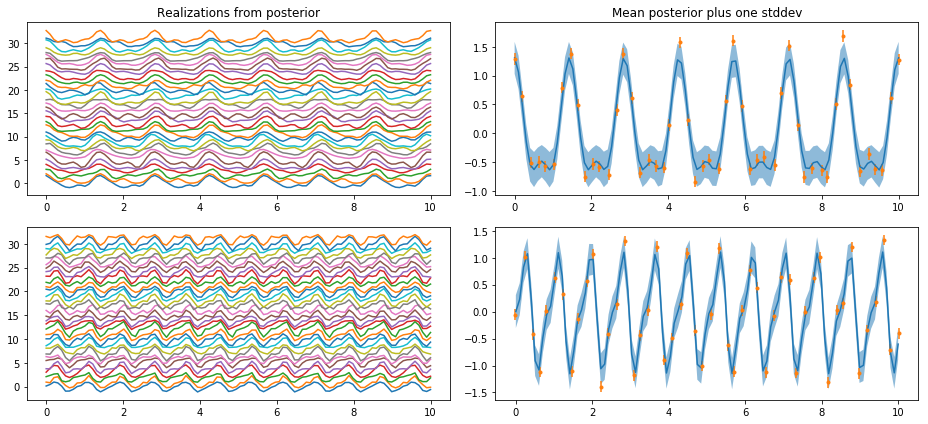

In [10]:
fig = plt.figure(figsize=(13, 6))

for i in range(2):
    ax = fig.add_subplot(2, 2, 2*i+1)
    if i == 0:
        ax.set_title('Realizations from posterior')
    mu, R, x = net.GP_fit_posterior(torch.from_numpy(mjd[i]).float(), 
                       torch.from_numpy(mag[i]).float(), 
                       torch.from_numpy(err[i]).float(), per[i], jitter=1e-5)
    z = net.sample_from_posterior(mu, R).detach().numpy()
    x = x[0,:].detach().numpy()
    mu = mu[0,:].detach().numpy()
    s = torch.sqrt(torch.sum(R**2, dim=0)).detach().numpy()
    for k in range(32):
        ax.plot(x, k+ z[k, :] )
    ax = fig.add_subplot(2, 2, 2*i+2)
    if i== 0:
        ax.set_title('Mean posterior plus one stddev')    
    ax.plot(x, mu)
    ax.fill_between(x, mu  - s, mu +s, alpha=0.5)
    ax.errorbar(mjd[i], mag[i], err[i], fmt='.')

plt.tight_layout();